In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
features = [
    "sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
    "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
    "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",  
    "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m",
]

In [3]:
import numpy as np
import torch
from fvt_classifier import FvTClassifier
from tst_info import TSTInfo
import yaml
import matplotlib.pyplot as plt

config_filename = "configs/counting_test_v1_base.yml"


config = yaml.safe_load(open(config_filename, "r"))
experiment_name = config["experiment_name"]
n_3b = config["n_3b"]
ratio_4b = config["ratio_4b"]


existing_hparams = TSTInfo.get_existing_hparams()
seeds = np.unique([h["seed"] for h in existing_hparams])
signal_ratios = np.unique([h["signal_ratio"] for h in existing_hparams])
n_3bs = np.unique([h["n_3b"] for h in existing_hparams])

In [7]:
hparams_filter = {
    "n_3b": n_3b,
    "signal_ratio": 0.0,
    "experiment_name": experiment_name,
    "seed": 0,
}
hashes = TSTInfo.find(hparams_filter)
tst_hash = hashes[0]

tst_info = TSTInfo.load(tst_hash)

In [8]:
from counting_test_v1 import get_is_signal
from dataset import SCDatasetInfo
from events_data import EventsData

def get_is_signal(scdinfo: SCDatasetInfo, signal_filename: str):
    # Now show the answer
    is_signals = []
    for file, file_len in zip(scdinfo.files, scdinfo.get_file_lengths()):
        is_signals.append(
            np.full(file_len, True)
            if file.name == signal_filename
            else np.full(file_len, False)
        )
    is_signal = np.concatenate(is_signals)
    return is_signal

def events_from_scdinfo(scdinfo: SCDatasetInfo, features: list, signal_filename: str) -> EventsData:
    df = scdinfo.fetch_data()
    df["signal"] = get_is_signal(scdinfo, signal_filename)
    events = EventsData.from_dataframe(df, features)

    return events

def hist_events_by_labels(events: EventsData, values: np.ndarray, bins, ax, **hist_kwargs):
    assert len(values) == len(events)   
    ax.hist(values[events.is_3b], 
                        bins=bins, histtype="step", label="3b", 
                        weights=events.weights[events.is_3b], 
                        **hist_kwargs)
    ax.hist(values[events.is_bg4b], 
                bins=bins, histtype="step", label="bg4b", 
                weights=events.weights[events.is_bg4b], 
                **hist_kwargs)
    ax.hist(values[events.is_signal], 
                bins=bins, histtype="step", label="signal", 
                weights=events.weights[events.is_signal], 
                **hist_kwargs)

signal_filename = "HH4b_picoAOD.h5"
events_tst = events_from_scdinfo(tst_info.scdinfo_tst, features, signal_filename)

In [9]:
base_fvt_model = FvTClassifier.load_from_checkpoint(f"checkpoints/{tst_info.base_fvt_tinfo_hash}_best.ckpt")
smeared_fvt_model = FvTClassifier.load_from_checkpoint(f"checkpoints/{tst_info.base_fvt_tinfo_hash}_best.ckpt")

: 

In [94]:
seed = 0
events_smear, events_test = events_tst.split(0.5, seed=seed)
events_smear_train, events_smear_val = events_smear.split(2/3, seed=seed)

In [100]:
from torch.utils.data import TensorDataset

noise_scale = 0.1
batch_size = 1024

events_smear_train.fit_batch_size(batch_size)
events_smear_val.fit_batch_size(batch_size)

base_scale = np.max(events_smear_train.X, axis=0) - np.min(events_smear_train.X, axis=0)
X_smeared_train = events_smear_train.X + noise_scale * base_scale * np.random.randn(*events_smear_train.X.shape)
X_smeared_val = events_smear_val.X + noise_scale * base_scale * np.random.randn(*events_smear_val.X.shape)

smeared_fvt_model.fit(
    TensorDataset(torch.tensor(X_smeared_train, dtype=torch.float32), 
                  events_smear_train.is_4b_torch,
                  events_smear_train.weights_torch),
    TensorDataset(torch.tensor(X_smeared_val, dtype=torch.float32),
                    events_smear_val.is_4b_torch,
                    events_smear_val.weights_torch),
    batch_size=batch_size,
    max_epochs=10,
    train_seed=seed,
)

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/soheuny/HH4bsim/playground/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 127/127 [00:04<00:00, 27.59it/s, v_num=2, val_loss=0.673, train_loss=0.673]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 127/127 [00:04<00:00, 26.91it/s, v_num=2, val_loss=0.673, train_loss=0.673]


In [101]:
base_fvt_model.eval()
smeared_fvt_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_fvt_model.to(device)
smeared_fvt_model.to(device)

probs_est_4b_base = base_fvt_model.predict(events_test.X_torch).detach().cpu().numpy()[:, 1]
probs_est_4b_smeared = smeared_fvt_model.predict(events_test.X_torch).detach().cpu().numpy()[:, 1]

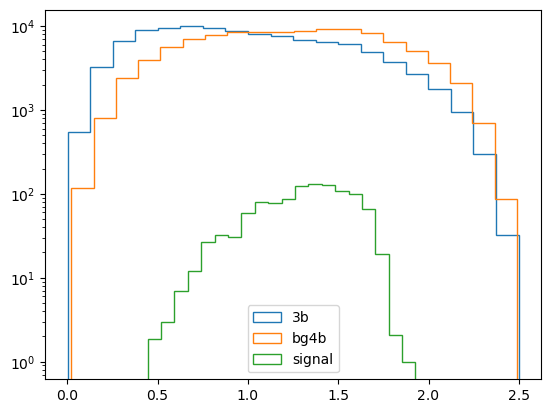

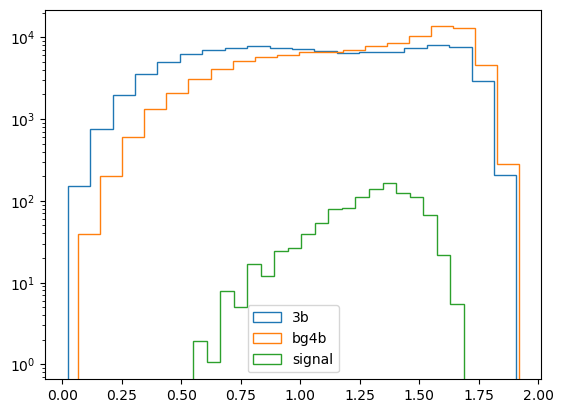

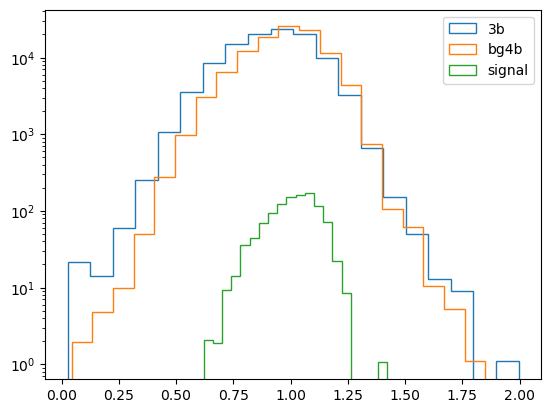

In [102]:
dr_4b_base = probs_est_4b_base / (1 - probs_est_4b_base)
dr_4b_smeared = probs_est_4b_smeared / (1 - probs_est_4b_smeared)

fig, ax = plt.subplots()
hist_events_by_labels(events_test, dr_4b_base, bins=20, ax=ax)
ax.set_yscale("log")
ax.legend()
plt.show()
plt.close()

fig, ax = plt.subplots()
hist_events_by_labels(events_test, dr_4b_smeared, bins=20, ax=ax)
ax.set_yscale("log")
ax.legend()
plt.show()
plt.close()

fig, ax = plt.subplots()
hist_events_by_labels(events_test, dr_4b_base / dr_4b_smeared, bins=20, ax=ax)
ax.set_yscale("log")
ax.legend()
plt.show()
plt.close()

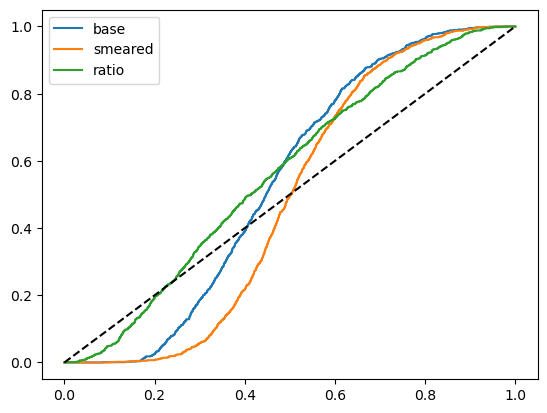

In [103]:
dr_4b_base_argsort = np.argsort(dr_4b_base)[::-1]
dr_4b_smeared_argsort = np.argsort(dr_4b_smeared)[::-1]
dr_4b_ratio_argsort = np.argsort(dr_4b_base / dr_4b_smeared)[::-1]

is_4b = events_test.is_4b
is_signal = events_test.is_signal
weights = events_test.weights
fig, ax = plt.subplots()
ax.plot(np.cumsum((weights * is_4b)[dr_4b_base_argsort]) / np.sum(weights * is_4b), 
        np.cumsum((weights * is_signal)[dr_4b_base_argsort]) / np.sum(weights * is_signal), label="base")
ax.plot(np.cumsum((weights * is_4b)[dr_4b_smeared_argsort]) / np.sum(weights * is_4b),
        np.cumsum((weights * is_signal)[dr_4b_smeared_argsort]) / np.sum(weights * is_signal), label="smeared")
ax.plot(np.cumsum((weights * is_4b)[dr_4b_ratio_argsort]) / np.sum(weights * is_4b),
        np.cumsum((weights * is_signal)[dr_4b_ratio_argsort]) / np.sum(weights * is_signal), label="ratio")
ax.plot([0, 1], [0, 1], linestyle="--", color="black")
ax.legend()
plt.show()